# FMNIST Classification using CNN

### About the Dataset

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. 
[More info.](https://github.com/zalandoresearch/fashion-mnist)

### Why Fashion-MNIST over MNIST?
- MNIST is too easy. Convolutional nets can achieve 99.7% on MNIST. Classic machine learning algorithms can also achieve 97% easily.
- MNIST is overused.
- MNIST can not represent modern CV tasks.

Let's now get going with it.

## 1. Importing packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

## 2. Downloading Dataset and applying Transformations.

In [2]:
# defining the transformations (converting the image into tensors).
transform = transforms.Compose([transforms.ToTensor()])

The Dataset could have been normalised, but as all the pixel values(features) range from 0 to 255, normalising the data doesn't seem necessary.

In [3]:
# trainset and testset
train_set = datasets.FashionMNIST(
    root = './data/FMNIST',
    train = True,
    download = True,
    transform = transform
)

test_set = datasets.FashionMNIST(
    root = './data/FMNIST',
    train = False,
    download = True,
    transform = transform
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



In [4]:
print(f'Train set : {len(train_set)}')
print(f'Test set : {len(test_set)}')

Train set : 60000
Test set : 10000


## 3. Exploring the data

In [5]:
from torch.utils.data import DataLoader
# Loading data into a DataLoader of batch size 64
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

In [6]:
# Unpacking the images and labels of a batch
images, labels = next(iter(train_loader))

Let's check the shapes of our images and labels.

In [7]:
print("Images' Shape : ", images.shape)
print("Labels' Shape : ", labels.shape)

Images' Shape :  torch.Size([64, 1, 28, 28])
Labels' Shape :  torch.Size([64])


The shape of the `images` tensor denotes the no of training examples in the batch, the no of color channels in the batch, and finally the height and width of every image.

The shape of the `labels` tensor is 64, as the labels contains the digit corresponding to the fashion item(ground-truth) for every single image in the dataset.

Let's see what the numbers in the labels in the dataset represent.

<table>
<thead>
<tr>
<th>Label</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td>0</td>
<td>T-shirt/top</td>
</tr>
<tr>
<td>1</td>
<td>Trouser</td>
</tr>
<tr>
<td>2</td>
<td>Pullover</td>
</tr>
<tr>
<td>3</td>
<td>Dress</td>
</tr>
<tr>
<td>4</td>
<td>Coat</td>
</tr>
<tr>
<td>5</td>
<td>Sandal</td>
</tr>
<tr>
<td>6</td>
<td>Shirt</td>
</tr>
<tr>
<td>7</td>
<td>Sneaker</td>
</tr>
<tr>
<td>8</td>
<td>Bag</td>
</tr>
<tr>
<td>9</td>
<td>Ankle boot</td>
</tr>
</tbody>
</table>

In [8]:
# dictionary mapping item numbers to item names
fashion_dict = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

Let's now see how the images look like along with their truth labels.

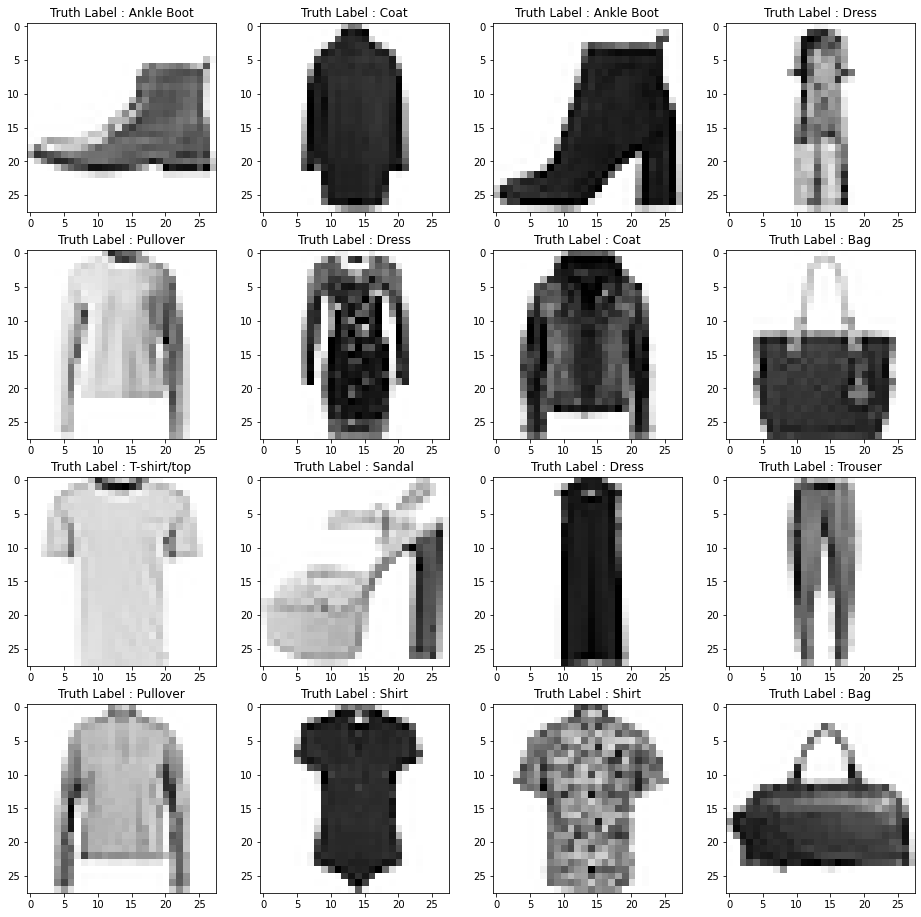

In [9]:
from IPython.core.pylabtools import figsize
# creating subplots 4x4 grid
fig, ax = plt.subplots(4,4, figsize=(16,16))

index = 0
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images[index].squeeze(), cmap='Greys')
        ax[i,j].set_title(f'Truth Label : {fashion_dict[labels[index].item()]}')
        index+=1

## 4. Designing the Convolutional Neural Network

The first convolutional layer takes in the original 28x28 and uses a `kernel` of size (5,5) which reduces the dimension of the new image to 24x24, followed by a `relu`, followed by `maxpooling` which in our case reduces the image dimensions further down by half to 12x12.
The `channels` are changed from 1 to 32.

The second convolutional layer does pretty much the same, further reducing the dimension to 4x4, and the channels from 32 to 64.

The image, thus obtained is `flattened` before sending it to the linear layers.

Next, it consists of 2 hidden layer with 128 and 64 neurons respectively.
And, finally an output layer with 10 neurons (= no of output classes).

In [10]:
# no of neurons in respective layers
output_sizes = 10
conv_channels = [32, 64]
hidden_sizes = [128, 64]

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # greyscale, hence in_channels = 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=conv_channels[0], kernel_size=5)                 # 1 -> 32
        self.conv2 = nn.Conv2d(in_channels=conv_channels[0], out_channels=conv_channels[1], kernel_size=5)  # 32 -> 64
        # image dimensions changing
        # 28 - 5 + 1 = 24, 24/2 = 12 (max pool), 12 - 5 + 1 = 8, 8/2 = 4 (max pool) 
        # therefore, in_features = 12 (channels) * 4*4 (image dimensions)
        self.linear1 = nn.Linear(in_features=conv_channels[1]*4*4, out_features=hidden_sizes[0])            # 64*4*4 -> 128
        self.linear2 = nn.Linear(in_features=hidden_sizes[0], out_features=hidden_sizes[1])                 # 128 -> 64
        self.out = nn.Linear(in_features=hidden_sizes[1], out_features=output_sizes)                        # 64  -> 10
        
    def forward(self, t):
        # (1) input layer
        t = t 
        
        # (2) conv1 layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) conv2 layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) linear layer 1
        t = t.reshape(-1, conv_channels[1]*4*4)
        t = self.linear1(t)
        t = F.relu(t)
        
        # (5) linear layer 2
        t = self.linear2(t)
        t = F.relu(t)
        
        # (6) output layer
        t = self.out(t)
        
        return t

Inside the network we usually use `relu()` as our non-linear activation function, but for the output layer, whenever we have a single category that we are trying to predict, we use `softmax()`. The softmax function returns a positive probability for each of the prediction classes, and the probabilities sum to 1.
However, in our case, we won't use `softmax()` because the loss function that we'll use, `nn.CrossEntropyLoss()`, implicitly performs the `softmax()` operation on its input, so we'll just return the result of the last linear transformation.

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
network_trial = CNN().to(device)

In [13]:
print(network_trial)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=1024, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [14]:
# print the summary of the network
from torchsummary import summary
summary(network_trial, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
            Conv2d-2             [-1, 64, 8, 8]          51,264
            Linear-3                  [-1, 128]         131,200
            Linear-4                   [-1, 64]           8,256
            Linear-5                   [-1, 10]             650
Total params: 192,202
Trainable params: 192,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.73
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


## 5. The Training Process

In [15]:
def get_num_correct(pred, labels):
    '''Returns number of labels predicted corrected'''
    return pred.argmax(dim=1).eq(labels).sum().item()

Getting ready for the training process, setting `hyperparameters`, `loss function` and `optimizer`.\
We will be trying out various values of our Hyperparameters, `learning_rates`, `batch_sizes`, `shuffle` and `devices` to get the best model.

In [16]:
from itertools import product

parameters = dict(
    lr = [.01, .001],
    batch_size = [100, 1000],
    shuffle = [True]
)
epochs = 20
param_values = [v for v in parameters.values()]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# selecting the loss function
criterion = nn.CrossEntropyLoss()

# creating a list of model for various sets of hyperparameter combination
networks = []

#### The Training Loop

The images have to be flattened out before feeding it to the CNN. Then, the batch is fed into the network. The outputs of the network is fed into the loss function with the truth labels. Then, the old gradients (from the previous iterations) are forced to 0 and backprop starts. The optimizer updates the weights at each iteration.

In [17]:
torch.manual_seed(42)

In [18]:
index = 0
for lr, batch_size, shuffle in product(*param_values):

    print(f'\nModel {index} : Batch size : {batch_size}, Learning Rate : {lr} Shuffle : {shuffle}\n')
    # using the dataloader to load batches of data
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
    
    device = torch.device(device)
    network = CNN().to(device)
    networks.append(network)
    index+=1
    
    # selecting the optimizer for the loss function
    optimizer = optim.Adam(network.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss=0
        total_correct=0
        for batch in train_loader:
            images = batch[0].to(device)
            labels = batch[1].to(device)
            
            # Forward Prop
            outputs = network(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad() # making previous grads 0
            loss.backward() # Calculate Gradients / Back Prop
            optimizer.step() # Update Weights
            
            total_loss += loss.item() # total loss over batches
            # the total loss has to be divided by `len(batches)` for the correct value
            total_correct += get_num_correct(outputs, labels)
        
        print(f'Epoch {epoch} - Training Loss : {total_loss/len(train_loader)}, Accuracy : {total_correct / len(train_set)}')


Model 0 : Batch size : 100, Learning Rate : 0.01 Shuffle : True

Epoch 0 - Training Loss : 0.4946302583316962, Accuracy : 0.8142333333333334
Epoch 1 - Training Loss : 0.3462678442398707, Accuracy : 0.8733166666666666
Epoch 2 - Training Loss : 0.31941358639548223, Accuracy : 0.8823
Epoch 3 - Training Loss : 0.29967345513403415, Accuracy : 0.8888833333333334
Epoch 4 - Training Loss : 0.29633087436358135, Accuracy : 0.8925666666666666
Epoch 5 - Training Loss : 0.28095711935311557, Accuracy : 0.8966166666666666
Epoch 6 - Training Loss : 0.2716044185558955, Accuracy : 0.8998666666666667
Epoch 7 - Training Loss : 0.2760137009620667, Accuracy : 0.89945
Epoch 8 - Training Loss : 0.27183501119414966, Accuracy : 0.9012166666666667
Epoch 9 - Training Loss : 0.27547573260962965, Accuracy : 0.9017
Epoch 10 - Training Loss : 0.25628736581653355, Accuracy : 0.9058333333333334
Epoch 11 - Training Loss : 0.25366005330036084, Accuracy : 0.9075166666666666
Epoch 12 - Training Loss : 0.25896492208043737,

The training accuracy of the model with `Batch size : 100, Learning Rate : 0.001 Shuffle : True` in `20 epochs` is already `97 %`. The model seems to be good enough.

In [19]:
networks[2]

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=1024, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)

Let's evaluate the `Model 2` on the test set now.

## 6. Evaluating the network

Using the test_loader to generate batches of test data and test the `Model 2` with it.

In [20]:
model = networks[2]

In [21]:
# turning shuffle off to get sequential indices for tracking incorrect prediction in the next 
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)

In [22]:
correct_count = 0
pred_labels = []

for images, labels in test_loader:


    for i in range(len(labels)):
        # getting individual images in the particular test loader
        image = images[i].to(device)
        # turning off gradients to save computation
        with torch.no_grad():
            outputs = model(image) # taking model 2 from list of models
            
        # squeezing the dimension of the output tensor from [[]] to []
        # taking argmax of the output and setting it as the predicted label
        pred_label = torch.argmax(outputs.squeeze())
        true_label = labels[i].to(device)
        
        if(true_label == pred_label):
            correct_count += 1

        pred_labels.append(pred_label.item()) # tracking all the predictions

print("Test Accuracy =", (correct_count/len(test_set)))

Test Accuracy = 0.9079


The test accuracy is about `90.8 %` which is great comapred to the ANN which gave train and test accuracy of 92 % and 88 %, but can we do it better, yet?

Let's now see the `confusion matrix` and find out where the model is getting confused.

In [23]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(test_set.targets.tolist(), pred_labels) 
print(confusion_mat)

[[857   0  11  14   7   2  98   0  11   0]
 [  4 975   0  15   4   0   0   0   2   0]
 [ 29   2 808  13  77   0  68   0   3   0]
 [ 14   2   8 915  44   0  13   0   4   0]
 [  2   1  22  15 923   0  33   0   3   1]
 [  0   0   0   0   0 978   0  17   0   5]
 [ 96   1  41  23  90   0 739   0  10   0]
 [  0   0   0   0   0   7   0 987   1   5]
 [  5   0   2   6   4   1   3   2 977   0]
 [  1   0   0   0   0   5   0  74   0 920]]


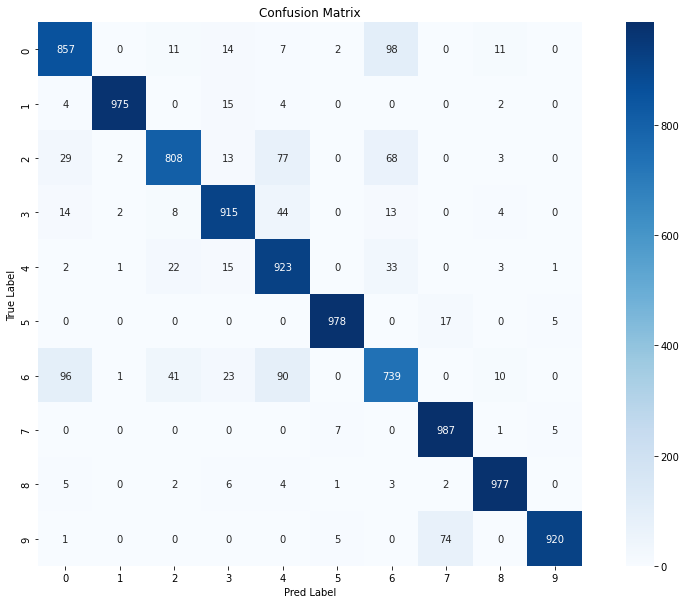

In [24]:
# plotting heatmap for the confusion matrix
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(confusion_mat, annot=True, fmt='.0f', ax=ax, cmap = "Blues", square=True)
plt.title("Confusion Matrix")
plt.xlabel("Pred Label")
plt.ylabel("True Label")
plt.show()

We see that :-

In [27]:
# interpret the confusion matrix
threshold = 50

for i in range(confusion_mat.shape[0]):
  for j in range(confusion_mat.shape[1]):
    if confusion_mat[i,j] >= threshold and i!=j:
      print(f'{fashion_dict[i]} has been wrongly categorized with {fashion_dict[j]}.')

T-shirt/top has been wrongly categorized with Shirt.
Pullover has been wrongly categorized with Coat.
Pullover has been wrongly categorized with Shirt.
Shirt has been wrongly categorized with T-shirt/top.
Shirt has been wrongly categorized with Coat.
Ankle Boot has been wrongly categorized with Sneaker.


Well, the results are here. Given an image of dimension 28x28 pixels, it can really be difficult to tell apart such close looking fashion items.

The model otherwise performs well enough. Given below is the classification report for the model.

In [29]:
from sklearn.metrics import classification_report
print(classification_report(test_set.targets.tolist(), pred_labels, target_names = list(fashion_dict.values())))

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.86      0.85      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.91      0.81      0.85      1000
       Dress       0.91      0.92      0.91      1000
        Coat       0.80      0.92      0.86      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.77      0.74      0.76      1000
     Sneaker       0.91      0.99      0.95      1000
         Bag       0.97      0.98      0.97      1000
  Ankle Boot       0.99      0.92      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



For now, we are not going deep into Overfitting and Regularization.

## 7. Visualizing the incorrect samples
Let's see and try to understand where our CNN is making errors.

In [30]:
pred_labels = torch.tensor(pred_labels)

# boolean array of test data labels vs predicted labels
incorrect = (test_set.targets != pred_labels).tolist()

# indexes of incorrect predictions
incorrect_indices = [i for i, x in enumerate(incorrect) if x]

In [33]:
# sampling only 6 incorrects predictions out of the all incorrects
import random
random.seed(34)
sample_incorrect = random.sample(incorrect_indices, 6)

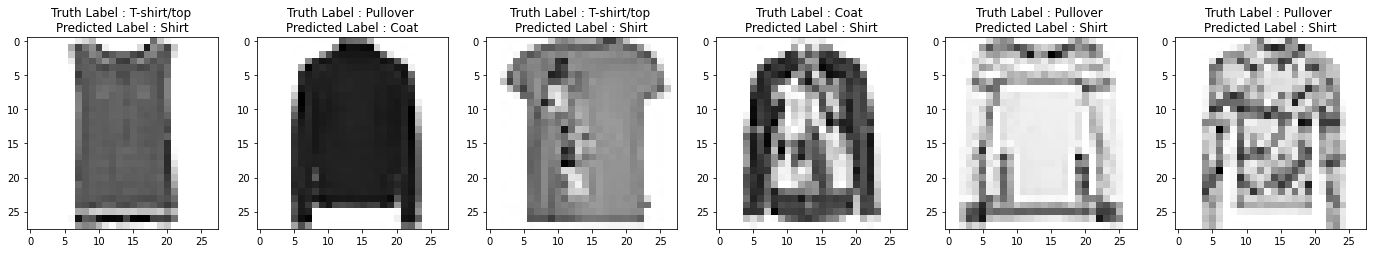

In [34]:
fig, ax = plt.subplots(1,6, figsize=(24,4))
index = 0
for i in sample_incorrect:
        ax[index].imshow(test_set.data[i].squeeze(), cmap='Greys')
        ax[index].set_title(f'Truth Label : {fashion_dict[test_set.targets[i].item()]} \nPredicted Label : {fashion_dict[pred_labels[i].item()]}')
        index+=1

If we see closely enough, our CNN is making mistakes when the images are close enough, which tells us how well our CNN is performing. The most common handicap being unable to tell shirt and t-shirt, pullover apart, coat and pullover apart, which is what we can by visualizing the confusion matrix. (Obviously, these were just 6 samples out of 855 errors, this might just be a very huge generalization.)

## 8. Visualizing Convolutional layer's Outputs (Feature Maps)
Let's now visualize what our convolutional layers are doing.
First, let's randomly select an image for the purpose and process it through the convolutional layers.

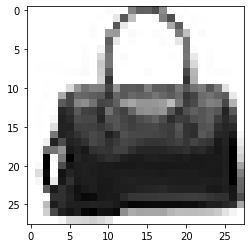

In [39]:
# setting the random seed
random.seed(34)
# selecting an image randomly
index = random.randint(0,10000)
# original image
image = test_set.data[index]
plt.imshow(image, cmap='Greys')

# getting the image ready for the convolutional layers
image = image.float().unsqueeze(dim=0).cuda()

In [40]:
image.shape

torch.Size([1, 28, 28])

In [41]:
# output of the conv layers
conv1_out = model.conv1(image)
conv2_out = model.conv2(conv1_out)

In [42]:
# bringing the data from gpu to cpu and converting the output of the conv layers to numpy array
conv1_imgs = conv1_out.cpu().data.numpy()
conv2_imgs = conv2_out.cpu().data.numpy()

Plotting the feature maps from the Convolutional layers

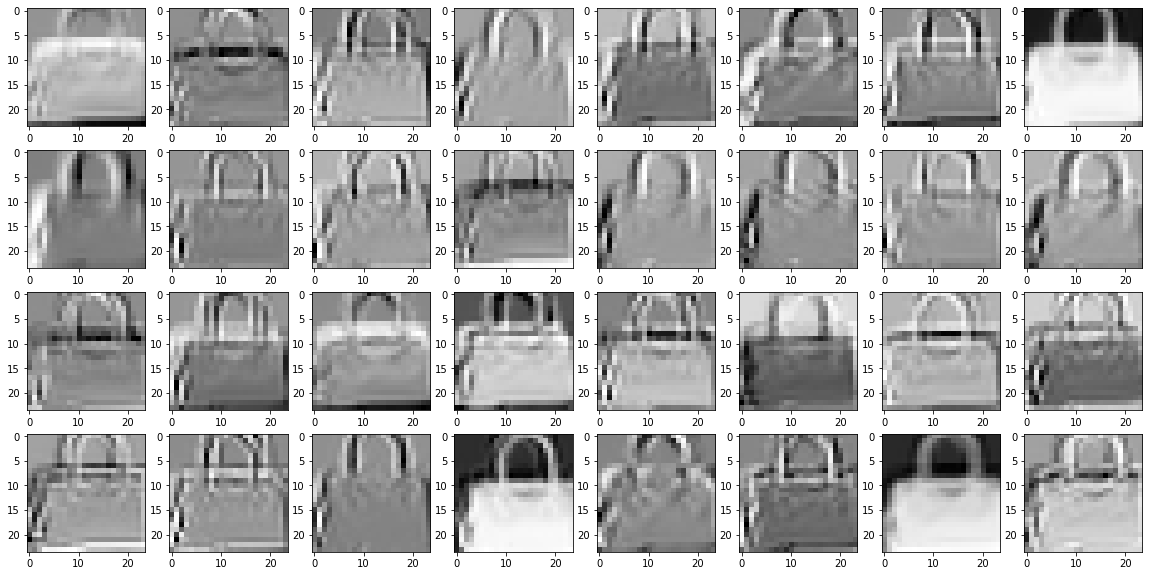

In [45]:
# plotting the feature maps from the 1st Convolutional layer
from matplotlib.pyplot import figure
figure(figsize=(20,10))

for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(conv1_imgs[i, :, :], cmap='Greys', )

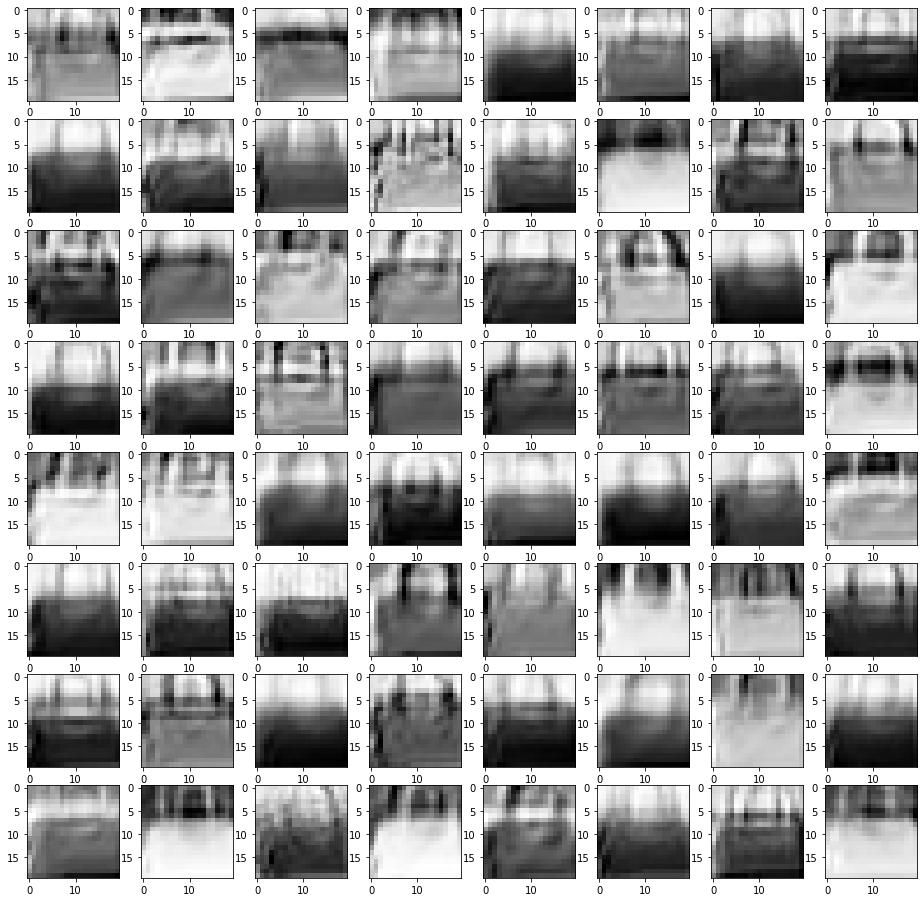

In [46]:
# plotting the feature maps from the 1st Convolutional layer
from matplotlib.pyplot import figure
figure(figsize=(16,16))

for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(conv2_imgs[i, :, :], cmap='Greys')

Disclaimer : The output of the 2nd Convolutional Layer should have been a 8x8 image (before the 2nd maxpooling), instead he have 20x20 images. That is because, we have ignored the 1st maxpooling after the 1st layer.

## 9. Saving the Model

In [47]:
# saving the entire model
torch.save(networks[2], "FMNIST_CNN_model.pt")

The model is ready to be loaded and used for predictions.

Done with it. Though there are still many things that can be done to improve the test accuracy and prevent Overfitting. However, that is not under the current scope.

# The End